In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error




In [106]:
df = pd.read_csv('movie_metadata.csv')


In [107]:
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


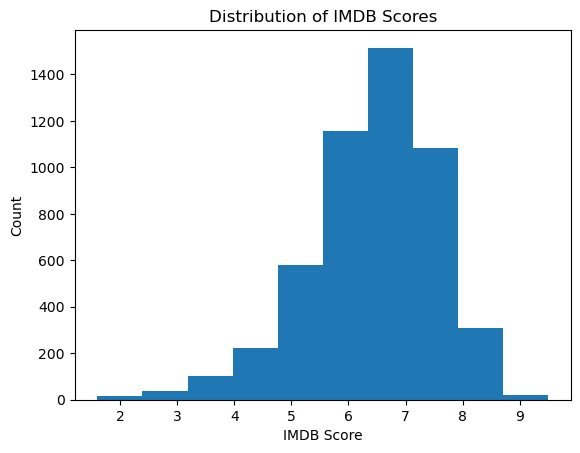

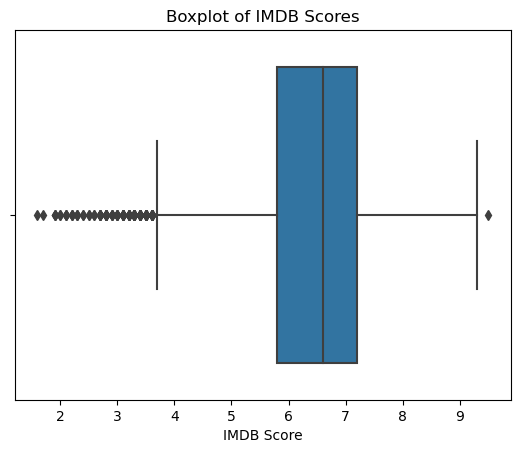

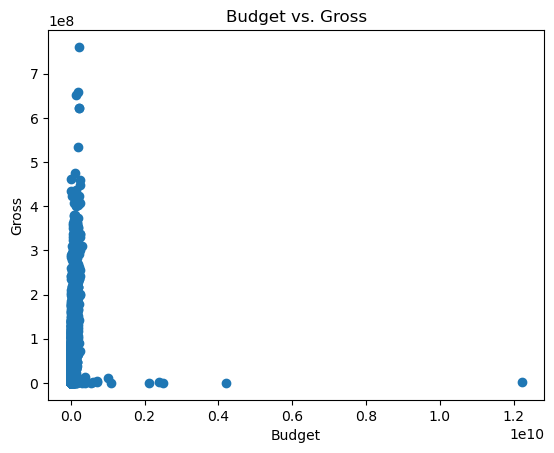

In [108]:
plt.hist(df['imdb_score'])
plt.title('Distribution of IMDB Scores')
plt.xlabel('IMDB Score')
plt.ylabel('Count')
plt.show()

sns.boxplot(x=df['imdb_score'])
plt.title('Boxplot of IMDB Scores')
plt.xlabel('IMDB Score')
plt.show()

plt.scatter(x=df['budget'], y=df['gross'])
plt.title('Budget vs. Gross')
plt.xlabel('Budget')
plt.ylabel('Gross')
plt.show()



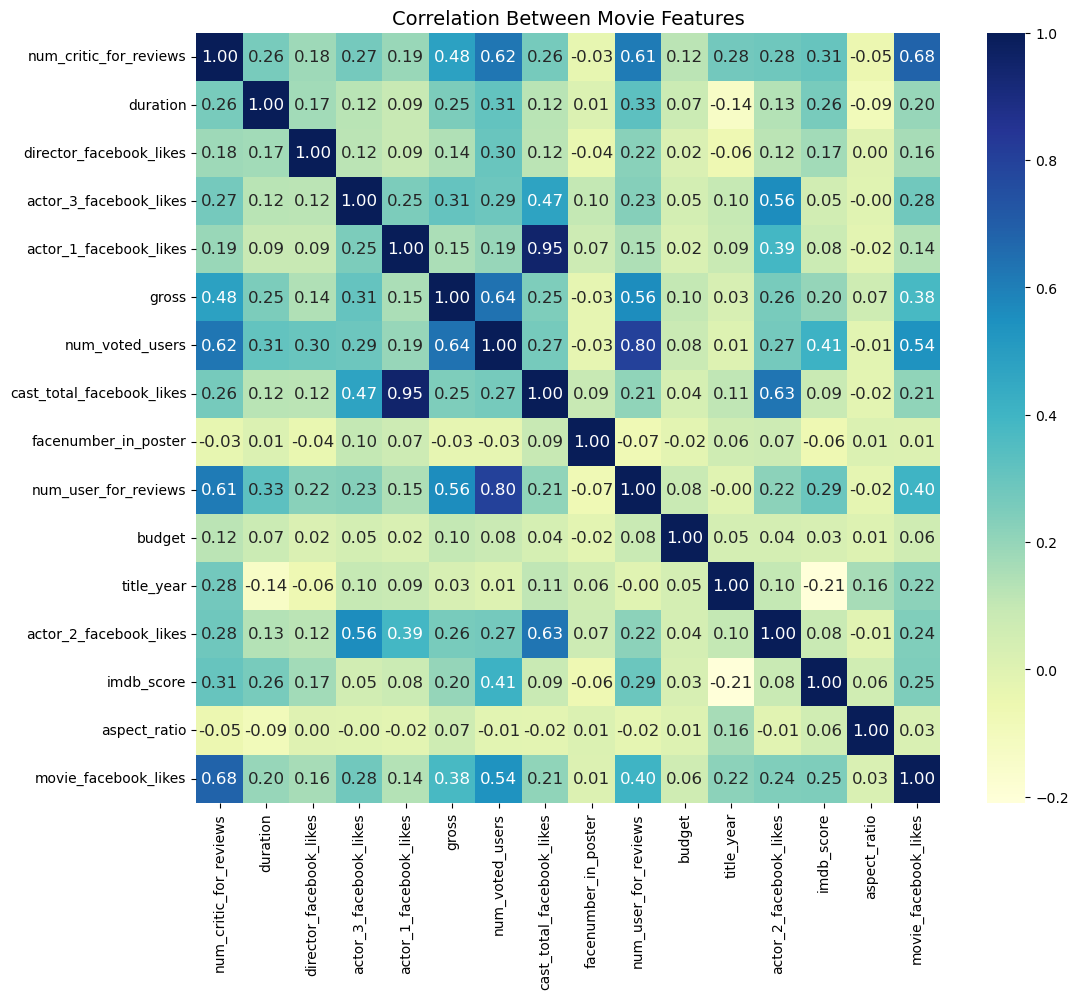

In [109]:
#correlation between movie features
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="YlGnBu", annot=True, fmt=".2f", annot_kws={'size':12})
plt.title('Correlation Between Movie Features', fontsize=14)
plt.show()

## Data Cleaning

In [110]:
#Missing values
missing_values_count = df.isnull().sum()
print(missing_values_count)

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64


In [111]:
df = df.drop(columns=['color'])

In [112]:
n_original = len(df)
df.dropna(inplace=True)
n_null_removed = len(df)
print(n_original,n_null_removed)
#we have 3756 rows after removing null values

5043 3757


In [113]:
# create binary variables for each genre
genres_df = df['genres'].str.get_dummies(sep='|')
# merge new dataframe with original dataframe
df = pd.concat([df, genres_df], axis=1)

## Feature Engineering: creating new variables that may be relevant to predicting movie profit

In [114]:
# Calculate gross profit as (gross - budget)
df['gross_profit'] = df['gross'] - df['budget']

# Calculate ratio of gross profit to budget
df['gross_budget_ratio'] = df['gross'] / df['budget']

# Calculate total number of actor likes
df['total_actor_likes'] = df['actor_1_facebook_likes'] + df['actor_2_facebook_likes'] + df['actor_3_facebook_likes'] + df['cast_total_facebook_likes']

In [115]:
# Create dummy variables for the language column
# specify columns to drop
cols_to_drop = ['genres', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'plot_keywords','movie_title','movie_imdb_link', 'country','content_rating','language']

# drop columns from df
df.drop(cols_to_drop, axis=1, inplace=True)

# Split the data into input features and target variable
X = df.drop(columns=['gross'])
y = df['gross']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




## Model 

In [116]:
# Create a separate regression model for each genre
models = {}
for genre in X_train.columns:
    if genre != 'gross':
        model = LinearRegression()
        model.fit(X_train[[genre]], y_train)
        models[genre] = model



# Fit the models on the training set
for genre, model in models.items():
    model.fit(X_train[[genre]], y_train)

In [117]:

# models = {}
# for genre in X_train.columns:
#     if genre != 'gross':
#         model = LinearRegression()
#         model.fit(X_train[[genre]], y_train)
#         models[genre] = model


In [118]:
#create model for each genre
from cmath import inf


models = {}
for genre in X_train.columns:
    if genre != 'gross':
        model = LinearRegression()
        model.fit(X_train[[genre]], y_train)
        models[genre] = model


# Calculate the RMSE for each model, predicting gross profit for each genre
#profit!
lowest_rsme = inf
genre = ''
for genre, model in models.items():
    y_pred = model.predict(X_test[[genre]])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    if rmse < lowest_rsme:
        lowest_rsme = rmse
        genre = genre



In [119]:
lowest_rsme

62889038.45748696

In [120]:
best_model

'num_voted_users'

In [126]:
#model summary for best model
best_model = models[genre]
best_model.fit(X_train[[genre]], y_train)
#we just fit the model on the training set, so we can use it to predict the test set
y_pred = best_model.predict(X_test[[genre]])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: ', rmse)
print('R2: ', best_model.score(X_test[[genre]], y_test))


RMSE:  75225701.79059324
R2:  0.06421080511709987
